In [1]:
%%writefile class_a.py
import dataclasses


@dataclasses.dataclass
class ClassA:
    aa : str = None
    ab : int = 0
        
    def print_content(self):
        print(self.__dict__)
        

Overwriting class_a.py


In [2]:
%%writefile class_b.py
import dataclasses
from class_a import ClassA

@dataclasses.dataclass
class ClassB(ClassA):
    ba : str = None
    bb : int = 0
        
    def print_content(self):
        print(self.__dict__)
        

Overwriting class_b.py


In [3]:
import graphviz as gv
import inspect
import types
import os
import sys
import glob
import importlib.util

In [4]:
from class_a import ClassA
from class_b import ClassB

In [5]:
import dataclasses

@dataclasses.dataclass
class DataClassBase:
    a : str = None
    b : int = 0
        
    def print_content(self):
        print(self.__dict__)

# print('='*80)
# display(DataClassBase.__dict__)
# print('-'*80)
# display(DataClassBase.__dir__(DataClassBase))

class ClassBase:
    c : str = None
    d : int = 0
    e = None
        
    def __init__(self, c: str = None, d: int = 0):
        self.c = c
        self.d = d
        
    def print_content(self):
        print(self.__dict__)
        
        
class ClassMixBase(DataClassBase, ClassBase):
    c : str = None
    d : int = 0
        
    def __init__(self, c: str = None, d: int = 0):
        self.c = c
        self.d = d
        
    def print_content(self):
        print(self.__dict__)
        
# print('='*80)
# display(ClassBase.__dict__)
# print('-'*80)
# display(ClassBase.__dir__(ClassBase))


In [6]:
(
    dataclasses.is_dataclass(DataClassBase),
    dataclasses.is_dataclass(ClassBase),
    dataclasses.is_dataclass(ClassMixBase)
)

(True, False, True)

In [7]:
def _get_fullname(entity):
    return '{}.{}'.format(entity.__module__, entity.__name__) 


def _get_methods(entity) -> list:
    return [
        k for k, v in entity.__dict__.items() 
        if not k.startswith('__') and isinstance(v, types.FunctionType)
    ]

def _get_dataclass_structure(klass):
    result = {'fields': {}, 'methods': _get_methods(klass)}
    
    result['fields'].update({
        k: v.type.__name__
        for k, v in klass.__dataclass_fields__.items()
    })
    return result


def _get_base_classes(klass):
    return [
        c for c in klass.__mro__
        if c.__name__ != 'object' and c.__name__ != klass.__name__ 
    ]


def _get_classicclass_structure(klass):
    _methods = _get_methods(klass)
    
    result = {
        'fields': {
            k: klass.__annotations__.get(k, object).__name__
            for k in klass.__dict__.keys()
            if not k.startswith('__') and k not in _methods
        }, 
        'methods': _methods
    }
    return result


def _get_class_structure(klass):
    if dataclasses.is_dataclass(klass):
        return _get_dataclass_structure(klass)
    elif inspect.isclass(klass):
        return _get_classicclass_structure(klass)

print(_get_class_structure(DataClassBase))
print(_get_class_structure(ClassBase))
# print(DataClassBase.__dir__(DataClassBase))
# display(DataClassBase.__dict__)

{'fields': {'a': 'str', 'b': 'int'}, 'methods': ['print_content']}
{'fields': {'c': 'str', 'd': 'int', 'e': 'object'}, 'methods': ['print_content']}


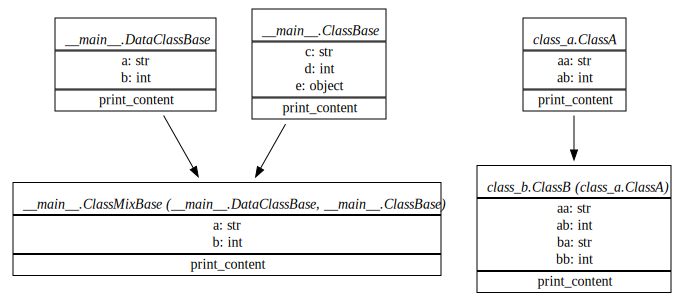

In [8]:
def _get_entity_class_html(entity):
    class_template = '''<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="1" CELLPADDING="1">
      <TR>
        <TD>{}</TD>
      </TR>
      <TR>
        <TD>
          <TABLE BORDER="0" CELLBORDER="0" CELLSPACING="0" CELLPADDING="1">
          {}
          </TABLE>
        </TD>
      </TR>
      <TR>
        <TD>
          <TABLE BORDER="0" CELLBORDER="0" CELLSPACING="0" CELLPADDING="1">
          {}
          </TABLE>
        </TD>
      </TR>
    </TABLE>>'''
    
    class_name_template = '<BR ALIGN="LEFT" />  <I>{}.{} {}</I> <BR ALIGN="LEFT" />'
    row_key_value_template = '<TR><TD>{}: {}</TD></TR>'
    row_key_template = '<TR><TD>{}</TD></TR>'
    
    empty_row = '<TR><TD></TD></TR>'
    base_classes = ', '.join([
        _get_fullname(c) for c in _get_base_classes(entity)
    ])
    
    if base_classes != '':
        base_classes = '({})'.format(base_classes)
    

    class_structure = _get_class_structure(entity)
    
    class_name = class_name_template.format(
        entity.__module__, entity.__qualname__, base_classes
    )
    attributes = ''.join([
        row_key_value_template.format(
            k, v
        ) for k, v in class_structure['fields'].items()
    ])
    
    methods = ''.join([
        row_key_template.format(k) 
        for k in class_structure['methods']
    ])
    
    return class_template.format(
        class_name,
        attributes if attributes else empty_row,
        methods if methods else empty_row
    )


def create_diagram(classes_list):    
    # to_graph(DataClassBase)
    g = gv.Digraph(comment='Graph')
    g.attr('node', shape='none', rankdir='BT')

    edges = []
    for c in classes_list:
        g.node(_get_fullname(c), _get_entity_class_html(c))

        for b in _get_base_classes(c):
            edges.append((_get_fullname(b), _get_fullname(c)))

    g.edges(edges)
    return g

    
classes_list = [
    DataClassBase, 
    ClassBase,
    ClassMixBase,
    ClassA,
    ClassB
]

create_diagram(classes_list)

In [11]:
def _serch_modules(target: str, exclude_pattern=['__pycache__']) -> list:
    results = []
    for f in glob.glob('{}/**/*'.format(target), recursive=True):
        skip = False
        for x in exclude_pattern:
            if x in f:
                skip = True
                break
        if not skip and f.endswith('.py'):
            results.append(f)
    return results

=========== /home/xmn/dev/xmnlab/pyuml/tests/notebooks/class_base.py ===========
No module named 'dataclass'
................................................................................


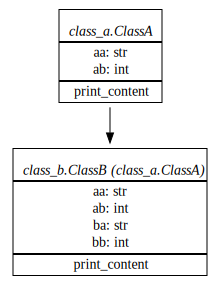

'/tmp/class_diagram1.png'

In [10]:
def _extract_filename(filename: str) -> str:
    return filename.split(os.sep)[-1].split('.')[0]


def _get_classes_from_module(module_path: str) -> list:
    spec = importlib.util.spec_from_file_location(
        _extract_filename(module_path), 
        module_path
    )
    module = importlib.util.module_from_spec(spec)
    
    classes_list = []
    
    try:
        spec.loader.exec_module(module)
        for o in module.__dir__():
            if o.startswith('__'):
                continue
            klass = getattr(module, o)
            if inspect.isclass(klass):
                classes_list.append(klass)
    except Exception as e:
        print(' {} '.format(module_path).center(80, '='))
        print(e)
        print('.' * 80)
    return classes_list
    
    
def run(target: str):
    classes_list = []
    
    if not os.path.exists(target):
        raise Exception('Path "{}" doesn\'t  exist.'.format(target))
    if os.path.isdir(target):
        sys.path.insert(0, target)

        for f in _serch_modules(target):
            classes_list.extend(_get_classes_from_module(f))
    return create_diagram(classes_list)

targets = !pwd
target = targets[0]

result = run(target)
display(result)
result.format = 'png'
result.render('/tmp/class_diagram1')